<a href="https://colab.research.google.com/github/JaiSuryaPrabu/deep_learning/blob/main/4_Paper_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Architecture

The paper : https://arxiv.org/pdf/2010.11929.pdf

* Collection of **layers** are called as **blocks**
* Collection of **blocks** makes the model architecture


## The main resource in the paper 
* The architecture image in **Fig 1**
* The mathematical equations in the **Section 3.1**
* The hyperparameter tuning in the **table 1**

## Stages 

### 1. Input
* Turn the input image into patches
* And number the patches
### 2. Embedded Patches
* Embedding is used to convert the *images* into *vectors*
### 3. Layer Normalization
* Called as **Norm**
* Regularizing the neural network *(Reducing the overfitting)*
* `torch.nn.LayerNorm()` is used to get **norm**
### 4. Multi Head Attention - MSA
### 5. MLP
* A Multi Layer Perceptron block contains
    1. `nn.Linear()` * 2 times
    2. `nn.GELU()` * 1 times
    3. `nn.Dropout()` * 1 times
### MLP Head
* This is the **output layer**
* This is the **classifier head**


## Mathematical Equations

### Equation 1
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}

---



This equation deals with the input image of
* Class tokens
* Patch embeddings
* Position embeddings
> **E** means Embedding

In the vector form it looks like
`input_image = [class_token,image_patch_1,image_patch_2,...]`

### Equation 2
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}


---



\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)
\end{aligned}

* It tells that for each layer from 1 to ℓ contains the **MSA** layer and the **Norm** 
* The $+$ is the **residual connection**
* Psudeo code
    * `output_msa_block = MSA_layer(Norm_layer(x_input)) + x_input`

### Equation 3
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}

---



* Same as the equation 2
* Pseudo code
    * `output_mlp_block = MLP_layer(Norm_layer(output_msa_block)) + output_msa_block`

### Equation 4
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}

---



* This is the last layer **L**
* This layer is wrapped by **Norm layer**
* The pseudo code
    * `y = linear_layer(Norm_layer(output_mlp_block[0]))`

# Implementation of math equations

## Data

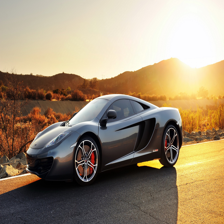

In [ ]:
from PIL import Image

image_size = 224
image = Image.open("car.jpg")
image = image.resize((image_size,image_size))
image.show()

In [ ]:
transform = transforms.ToTensor()
image_tensor = transform(image)
image_tensor,image_tensor.dtype

(tensor([[[0.6902, 0.6941, 0.6941,  ..., 0.9765, 0.9765, 0.9765],
          [0.6941, 0.6941, 0.6941,  ..., 0.9765, 0.9765, 0.9804],
          [0.6941, 0.6941, 0.6941,  ..., 0.9804, 0.9804, 0.9804],
          ...,
          [0.1725, 0.1725, 0.1922,  ..., 0.8196, 0.8314, 0.8157],
          [0.1804, 0.1569, 0.1725,  ..., 0.7686, 0.7529, 0.8431],
          [0.1647, 0.1922, 0.1569,  ..., 0.8000, 0.7608, 0.7922]],
 
         [[0.6863, 0.6902, 0.6902,  ..., 0.9412, 0.9412, 0.9412],
          [0.6902, 0.6941, 0.6941,  ..., 0.9412, 0.9412, 0.9412],
          [0.6941, 0.6941, 0.6941,  ..., 0.9451, 0.9451, 0.9451],
          ...,
          [0.1725, 0.1804, 0.2000,  ..., 0.5647, 0.5961, 0.5608],
          [0.1882, 0.1686, 0.1804,  ..., 0.5137, 0.4784, 0.5765],
          [0.1765, 0.2000, 0.1686,  ..., 0.5373, 0.4902, 0.5451]],
 
         [[0.6667, 0.6667, 0.6667,  ..., 0.9059, 0.9059, 0.9059],
          [0.6706, 0.6627, 0.6627,  ..., 0.9059, 0.9059, 0.9059],
          [0.6627, 0.6627, 0.6627,  ...,

## Equation 1


* The input size must be height of 224 , width of 224
* `Image size = ( H , W , C ) -> ( num_of_patches , (P.P.C) )`
* For example,
    * for ViT Base model,
        * patch size = 16 
        * H = 224
        * W = 224
        * C = 3
        * num_of_patches = 196
        * Embedded Size (D) = P.P.C = 768

In [ ]:
# from the given paper
height = 224        # H
width = 224         # W
color_channels = 3  # C
patch_size = 16     # P

# number of patches
num_of_patches = int( ( height * width ) / patch_size ** 2 )
print(f"The number of patches is {num_of_patches}") 

The number of patches is 196


In [ ]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Converting the image to patches
The image is patched into 16 rows and 16 columns  

In [ ]:
image_tensor.size(),image_tensor.permute(1,2,0).size() # [Color channel , Height , Width] , [Height , Width , Color channel]

(torch.Size([3, 224, 224]), torch.Size([224, 224, 3]))

(-0.5, 223.5, 223.5, -0.5)

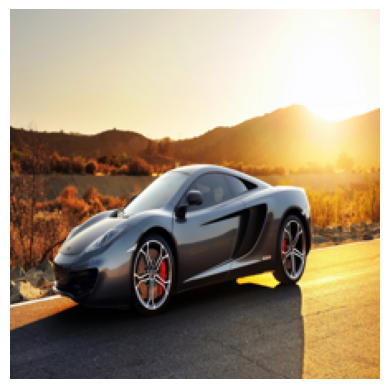

In [ ]:
# view of the image
from matplotlib import pyplot as plt

plt.imshow(image_tensor.permute(1,2,0))
plt.axis(False)

### Patching a single row

(-0.5, 223.5, 15.5, -0.5)

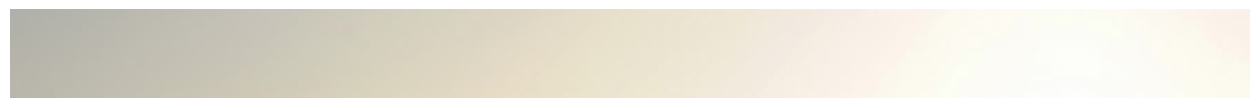

In [ ]:
# visualizing the top row
permuted_image = image_tensor.permute(1,2,0)
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(permuted_image[:patch_size,:,:])
plt.axis(False)

### Patching the first row + column

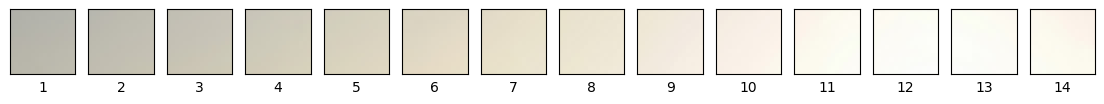

In [ ]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 

fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(permuted_image[:patch_size, patch:patch+patch_size, :]); 
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### Patching the entire image

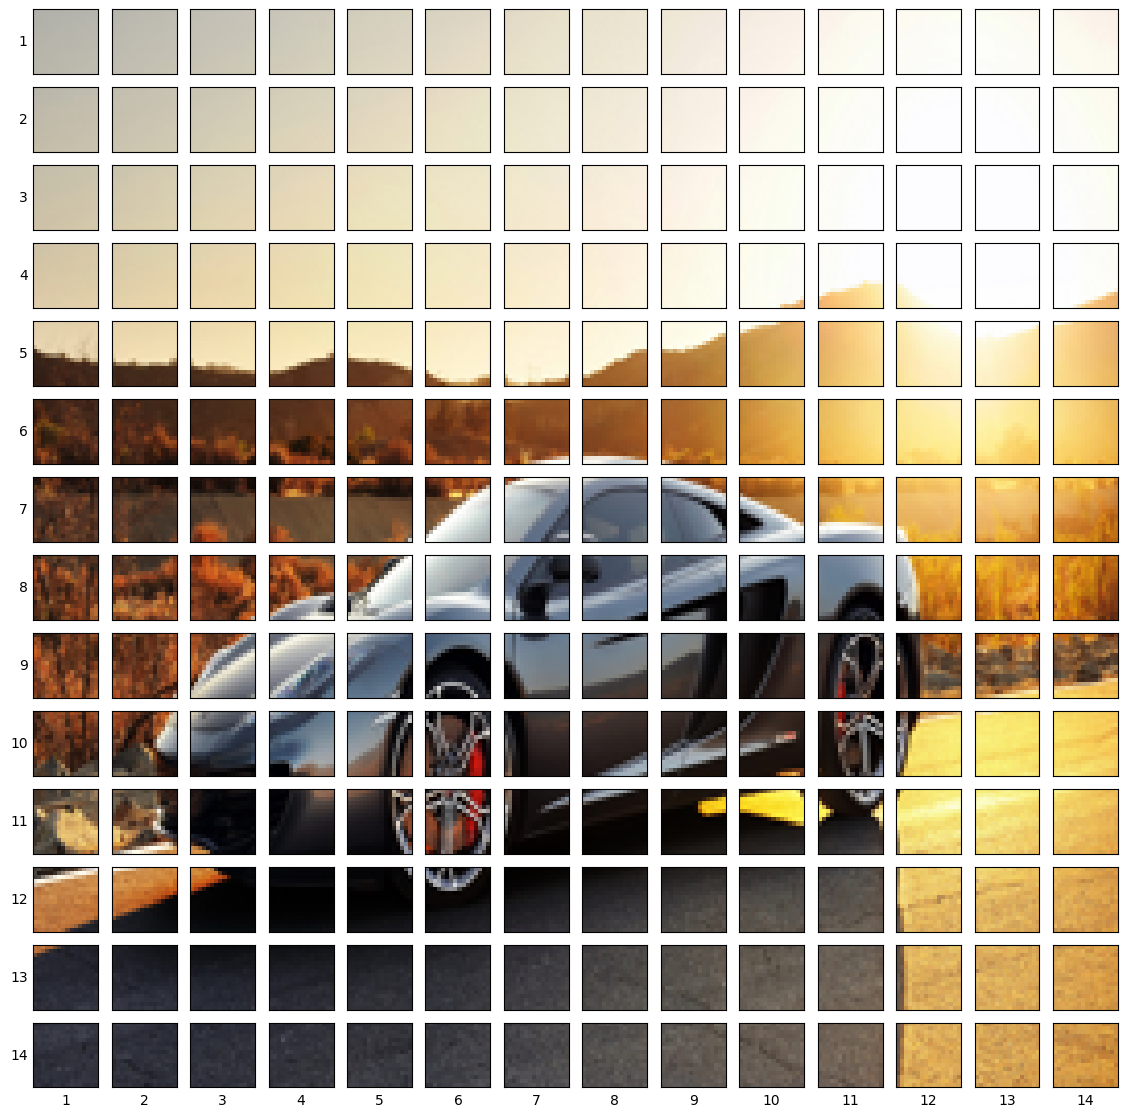

In [ ]:

img_size = 224
patch_size = 16
num_patches = img_size/patch_size 

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)): 
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        axs[i, j].imshow(permuted_image[patch_height:patch_height+patch_size,  
                                        patch_width:patch_width+patch_size,
                                        :]) 
        
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
plt.show()